dans la plupart des articles que nous avons vu CRF-LSTM pour modéliser la structure séquentielle de nos phrases. Nous avons utilisé le LSTM au niveau des mots et appliqué des embeddings de mots. Bien que cette approche soit simple et donne souvent de bons résultats, il existe des lacunes potentielles. Si nous n’avons pas vu un mot à une heure de prédiction, nous devons l’encoder comme inconnu et en déduire sa signification par les mots qui l’entourent. Souvent, le mot suffixe ou préfixe contient beaucoup d'informations sur la signification du mot. L'utilisation de ces informations est très importante si vous traitez avec des textes contenant beaucoup de mots rares et que vous vous attendez à beaucoup de mots inconnus au moment de l'inférence. Par exemple lorsque vous travaillez avec des textes médicaux.

Pour encoder les informations au niveau des caractères, nous utiliserons des imbrications de caractères et un LSTM pour encoder chaque mot en un vecteur. Nous pouvons utiliser essentiellement tout ce qui produit un seul vecteur pour une séquence de caractères représentant un mot. Vous pouvez également utiliser une architecture de pooling maximal ou un CNN ou tout ce qui fonctionne pour vous. Ensuite, nous transmettons le vecteur à un autre LSTM avec l'incorporation du mot appris.

Nous commençons par charger les données.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("dataAnnotated.csv", encoding="utf-8")

In [2]:
data = data.fillna(method="ffill")

In [3]:
data.head(60)

,Line#,Word,Tag
0,Line0,De,NoTag
1,Line0,tous,NoTag
2,Line0,les,NoTag
3,Line0,poëtes,NoTag
4,Line0,de‧l',NoTag
5,Line0,"Antiquité,",NoTag
6,Line0,Pindare,OEUVRES
7,Line1,est,NoTag
8,Line1,certainement,NoTag
9,Line1,aujourd',NoTag


In [4]:
words = list(set(data["Word"].values))
n_words = len(words); n_words

35708

In [5]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

7

Nous avons donc 47959 phrases contenant 35178 mots différents avec 17 balises différentes. Nous utilisons la classe SentenceGetter du dernier message pour récupérer des phrases avec leurs étiquettes.

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Line#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Line{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

Voici à quoi ressemble une phrase maintenant.

In [7]:
getter = SentenceGetter(data) #obtenir toutes les phrases.
sen = getter.get_next()
print(sen)

[('est', 'NoTag'), ('certainement', 'NoTag'), ("aujourd'", 'NoTag'), ('hui', 'NoTag'), ('le', 'NoTag'), ('plus', 'NoTag'), ('éloigné', 'NoTag'), ('de', 'NoTag'), ('nous.', 'NoTag'), ('Plus', 'NoTag'), ("qu'", 'NoTag'), ('aucun', 'NoTag'), ('des', 'NoTag'), ('grands', 'NoTag'), ('écrivains,', 'NoTag'), ('il', 'NoTag'), ('appartient', 'NoTag'), ('à', 'NoTag'), ('son', 'NoTag'), ('temps', 'NoTag'), ('et', 'NoTag'), ('ne', 'NoTag'), ('le', 'NoTag'), ('dépasse', 'NoTag'), ('guère.', 'NoTag'), ('Il', 'NoTag'), ('incarne', 'NoTag'), ('les', 'NoTag'), ('idées,', 'NoTag'), ('les', 'NoTag'), ('sentiments', 'NoTag'), ('de', 'NoTag'), ('son', 'NoTag'), ('époque', 'NoTag'), ('sans', 'NoTag'), ('jamais', 'NoTag'), ('les', 'NoTag'), ('dominer', 'NoTag'), ('-', 'NoTag'), ('autrement', 'NoTag'), ('que', 'NoTag'), ('par', 'NoTag'), ('la', 'NoTag'), ('beauté', 'NoTag'), ('de', 'NoTag'), ('son', 'NoTag'), ('style.', 'NoTag'), ('Que', 'NoTag'), ('dis-je?', 'NoTag'), ('Ce', 'NoTag'), ('ne', 'NoTag'), ('sont

Maintenant, nous introduisons des dictionnaires de mots et de balises.

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [9]:
max_len = 75
max_len_char = 20
n_words+=20

Maintenant, nous mappons les phrases à une séquence de nombres, puis nous remplissons la séquence. Notez que nous avons augmenté l'index des mots de un pour utiliser zéro comme valeur de remplissage. Ceci est fait parce que nous voulons utiliser le paramètre mask_zero du calque d'intégration pour ignorer les entrées avec la valeur zéro.

et Nous devons aussi générer un dictionnaire pour les caractères que nous voulons utiliser et créer la séquence de caractères pour chaque jeton. Notez que nous, plutôt arbitraire, fixons max_len_char à 10. Nous pourrions également utiliser des séquences plus longues ou plus courtes. On pourrait même utiliser deux séquences, une avec les cinq premiers caractères et une avec les cinq derniers caractères.

In [10]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

125


Et nous devons faire de même pour votre séquence de balises.

In [11]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


séparer les données en train et ensemble de test.

In [12]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [13]:
from keras.models import Model,Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [14]:
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char) #LSTM des characteres 

x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x) #Bi-LSTM des mots 
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)


Maintenant, nous pouvons compiler le modèle comme toujours et regarder le résumé.

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 20)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 75, 20, 10)   1270        input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 20)       714600      input_1[0][0]                    
_______________________________________________________________________________________

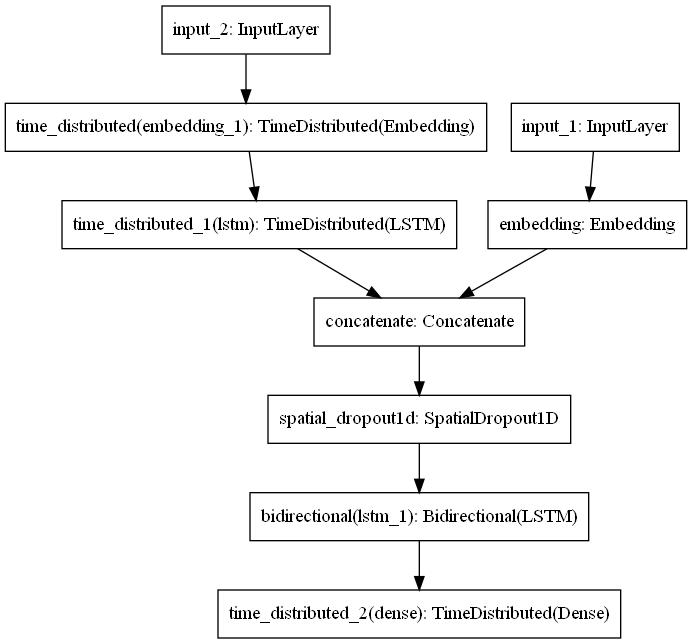

In [15]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()
from keras.utils import plot_model
plot_model(model)

In [16]:
history2 = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)


Epoch 1/10
255/255 [==============================] - 73s 285ms/step - loss: 0.1121 - acc: 0.9632 - val_loss: 0.0398 - val_acc: 0.9668
Epoch 2/10
255/255 [==============================] - 59s 233ms/step - loss: 0.0374 - acc: 0.9668 - val_loss: 0.0326 - val_acc: 0.9713
Epoch 3/10
255/255 [==============================] - 67s 263ms/step - loss: 0.0273 - acc: 0.9784 - val_loss: 0.0188 - val_acc: 0.9866
Epoch 4/10
255/255 [==============================] - 62s 245ms/step - loss: 0.0157 - acc: 0.9892 - val_loss: 0.0118 - val_acc: 0.9914
Epoch 5/10
255/255 [==============================] - 65s 255ms/step - loss: 0.0103 - acc: 0.9925 - val_loss: 0.0089 - val_acc: 0.9932
Epoch 6/10
255/255 [==============================] - 60s 234ms/step - loss: 0.0073 - acc: 0.9946 - val_loss: 0.0076 - val_acc: 0.9934
Epoch 7/10
255/255 [==============================] - 62s 243ms/step - loss: 0.0056 - acc: 0.9957 - val_loss: 0.0068 - val_acc: 0.9932
Epoch 8/10
255/255 [==============================] - 6

In [17]:
hist2 = pd.DataFrame(history2.history)

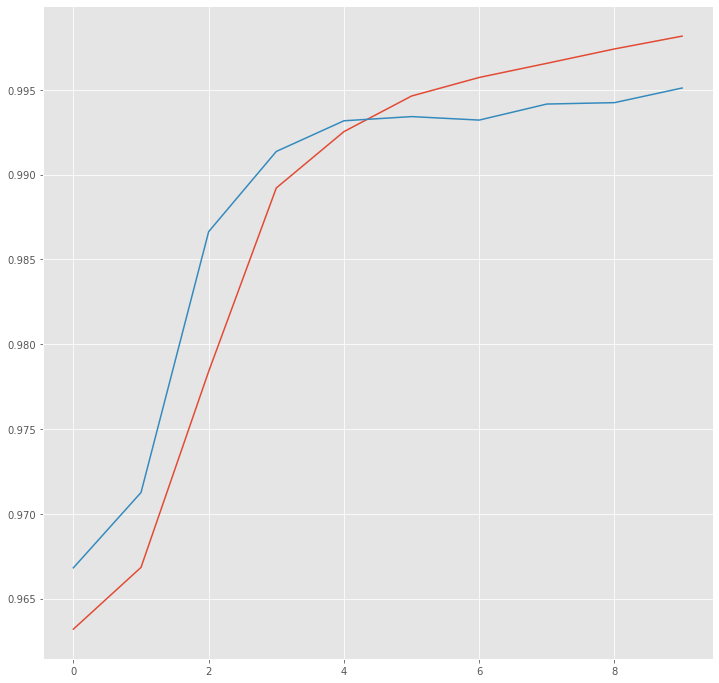

In [18]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist2["acc"])
plt.plot(hist2["val_acc"])
plt.show()

In [19]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

Prédictions sur les données de test :

In [20]:
for i in range(1000) : 
    p = np.argmax(y_pred[i], axis=-1)
    print(
        "{:15}||{:5}||{}".format("Word", "True", "Pred"))
    print(30 * "=")
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
                print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
sont           : NoTag NoTag
particulièrement: NoTag NoTag
denses         : NoTag NoTag
et             : NoTag NoTag
bien           : NoTag NoTag
écrites.       : NoTag NoTag
Elles          : NoTag NoTag
offrent        : NoTag NoTag
de             : NoTag NoTag
plus           : NoTag NoTag
l'             : NoTag NoTag
avantage       : NoTag NoTag
d'             : NoTag NoTag
avoir          : NoTag NoTag
une            : NoTag NoTag
signification  : NoTag NoTag
générale.      : NoTag NoTag
Je             : NoTag NoTag
veux           : NoTag NoTag
dire           : NoTag NoTag
par            : NoTag NoTag
là             : NoTag NoTag
qu'            : NoTag NoTag
elles          : NoTag NoTag
offrent        : NoTag NoTag
des            : NoTag NoTag
images         : NoTag NoTag
de‧la          : NoTag NoTag
vie            : NoTag NoTag
qui            : NoTag NoTag
ont            : NoTag NoTag
un             : NoTag NoTag
sens           : NoTag NoTag
et           

du             : NoTag NoTag
livre,         : NoTag NoTag
nous           : NoTag NoTag
n'             : NoTag NoTag
ignorerons     : NoTag NoTag
plus           : NoTag NoTag
Word           ||True ||Pred
MARGUERITE YOURCENAR: AUTHORS AUTHORS
-              : NoTag NoTag
Word           ||True ||Pred
acre,          : NoTag NoTag
par            : NoTag NoTag
pleines        : NoTag NoTag
pages,         : NoTag NoTag
avec           : NoTag NoTag
la             : NoTag NoTag
sérénité       : NoTag NoTag
qu'            : NoTag NoTag
elle           : NoTag NoTag
prête          : NoTag NoTag
à              : NoTag NoTag
ses            : NoTag NoTag
fugaces        : NoTag NoTag
héroïnes       : NoTag NoTag
féminines.     : NoTag NoTag
Femmes,        : NoTag NoTag
figures        : NoTag NoTag
de‧la          : NoTag NoTag
mort ;         : NoTag NoTag
hommes,        : NoTag NoTag
résistant      : NoTag NoTag
tenacement     : NoTag NoTag
à              : NoTag NoTag
cette          : NoTag NoTag
secrè

un             : NoTag NoTag
romancier      : NoTag NoTag
plus           : NoTag NoTag
difficile.     : NoTag NoTag
Il             : NoTag NoTag
fournit        : NoTag NoTag
un             : NoTag NoTag
mode           : NoTag NoTag
de             : NoTag NoTag
connaissance   : NoTag NoTag
utile          : NoTag NoTag
car            : NoTag NoTag
peu            : NoTag NoTag
de             : NoTag NoTag
gens           : NoTag NoTag
sont           : NoTag NoTag
capables       : NoTag NoTag
de             : NoTag NoTag
réfléchir      : NoTag NoTag
par            : NoTag NoTag
eux-mêmes.     : NoTag NoTag
Word           ||True ||Pred
D'             : NoTag NoTag
après          : NoTag NoTag
ses            : NoTag NoTag
photos,        : NoTag NoTag
on             : NoTag NoTag
ne             : NoTag NoTag
l'             : NoTag NoTag
imagine        : NoTag NoTag
 pas           : NoTag NoTag
frivole.       : NoTag NoTag
Tous           : NoTag NoTag
ses            : NoTag NoTag
livres        

Hollande       : LIEUX LIEUX
Word           ||True ||Pred
sa             : NoTag NoTag
plume :        : NoTag NoTag
« On           : NoTag NoTag
jette          : NoTag NoTag
un             : NoTag NoTag
œil            : NoTag NoTag
par            : NoTag NoTag
la             : NoTag NoTag
fente.         : NoTag NoTag
Grèce          : LIEUX LIEUX
Word           ||True ||Pred
,              : NoTag NoTag
indigne        : NoTag NoTag
de             : NoTag NoTag
s'             : NoTag NoTag
appeler        : NoTag NoTag
Alexandre,     : NoTag NoTag
s'             : NoTag NoTag
y              : NoTag NoTag
emploie        : NoTag NoTag
avec           : NoTag NoTag
une            : NoTag NoTag
légèreté       : NoTag NoTag
d'             : NoTag NoTag
éléphant.      : NoTag NoTag
César          : PERSONNAGES PERSONNAGES
Word           ||True ||Pred
Bernard Palissy: AUTHORS AUTHORS
Word           ||True ||Pred
Jean-Claude Ollier: CRITIQUES CRITIQUES
Word           ||True ||Pred
On             :

voix »         : NoTag NoTag
Mémoires       : OEUVRES OEUVRES
Word           ||True ||Pred
(13)           : NoTag NoTag
S.P            : OEUVRES OEUVRES
.,             : NoTag NoTag
p.219.         : NoTag NoTag
Word           ||True ||Pred
;              : NoTag NoTag
Sophocle       : AUTHORS AUTHORS
Word           ||True ||Pred
On             : NoTag NoTag
ne             : NoTag NoTag
peut           : NoTag NoTag
nier           : NoTag NoTag
que            : NoTag NoTag
Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
,              : NoTag NoTag
il             : NoTag NoTag
était          : NoTag NoTag
devenu         : NoTag NoTag
mon            : NoTag NoTag
chien ;        : NoTag NoTag
c'             : NoTag NoTag
est-à-dire     : NoTag NoTag
qu'            : NoTag NoTag
il             : NoTag NoTag
gardait        : NoTag NoTag
jalousement    : NoTag NoTag
mon            : NoTag NoTag
berceau        : NoTag NoTag
d'             : NoTag NoTag
enfant,        : NoTag

,              : NoTag NoTag
Editions       : NoTag NoTag
Gallimard      : INSTITUTIONS INSTITUTIONS
Word           ||True ||Pred
dont,          : NoTag NoTag
grâce          : NoTag NoTag
à              : NoTag NoTag
Menling        : PERSONNAGES LIEUX
Word           ||True ||Pred
.              : NoTag NoTag
Thésée         : NoTag NoTag
y              : NoTag NoTag
amène          : NoTag NoTag
les            : NoTag NoTag
quatorze       : NoTag NoTag
victimes       : NoTag NoTag
qui            : NoTag NoTag
sont           : NoTag NoTag
le             : NoTag NoTag
tribut         : NoTag NoTag
que            : NoTag NoTag
les            : NoTag NoTag
Grecques       : NoTag NoTag
offrent        : NoTag NoTag
chaque         : NoTag NoTag
année          : NoTag NoTag
au             : NoTag NoTag
monstre        : NoTag NoTag
crêtois,       : NoTag NoTag
le             : NoTag NoTag
Minotaure.     : NoTag NoTag
Les            : NoTag NoTag
victimes       : NoTag NoTag
parlent        : NoTag 

Word           ||True ||Pred
Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
de‧la          : NoTag NoTag
circulation    : NoTag NoTag
du             : NoTag NoTag
sang ;         : NoTag NoTag
Pasteur        : PERSONNAGES NoTag
fut            : NoTag NoTag
en             : NoTag NoTag
butte          : NoTag NoTag
aux            : NoTag NoTag
attaques       : NoTag NoTag
de‧la          : NoTag NoTag
médecine       : NoTag NoTag
académique     : NoTag NoTag
attardée.      : NoTag NoTag
Word           ||True ||Pred
ar             : NoTag NoTag
grande         : NoTag NoTag
serait         : NoTag NoTag
autrement      : NoTag NoTag
la             : NoTag NoTag
tentation      : NoTag NoTag
de‧la          : NoTag NoTag
comparer       : NoTag NoTag
à              : NoTag NoTag
cet            : NoTag NoTag
Anglais        : NoTag NoTag
d'             : NoTag NoTag
une            : NoTag NoTag
autre          : NoTag NoTag
époque         : NoTag NoTag
débarquant     : NoTag NoTag

minuscule      : NoTag NoTag
combat         : NoTag NoTag
est            : NoTag NoTag
emblématique   : NoTag NoTag
du             : NoTag NoTag
malentendu     : NoTag NoTag
persistant     : NoTag NoTag
entre          : NoTag NoTag
les            : NoTag NoTag
hommes         : NoTag NoTag
et             : NoTag NoTag
les            : NoTag NoTag
femmes,        : NoTag NoTag
et             : NoTag NoTag
des            : NoTag NoTag
préjugés       : NoTag NoTag
éternels.      : NoTag NoTag
Il             : NoTag NoTag
n'             : NoTag NoTag
est            : NoTag NoTag
pas            : NoTag NoTag
sûr            : NoTag NoTag
qu'            : NoTag NoTag
il             : NoTag NoTag
ne             : NoTag NoTag
se             : NoTag NoTag
trouverait     : NoTag NoTag
pas            : NoTag NoTag
aujourd'       : NoTag NoTag
hui            : NoTag NoTag
une            : NoTag NoTag
journaliste    : NoTag NoTag
pour           : NoTag NoTag
commencer      : NoTag NoTag
son           

cet            : NoTag NoTag
ordre,         : NoTag NoTag
elle           : NoTag NoTag
a              : NoTag NoTag
Word           ||True ||Pred
M.             : NoTag NoTag
Y. :           : NoTag NoTag
Oui.           : NoTag NoTag
Seulement      : NoTag NoTag
ils            : NoTag NoTag
ne             : NoTag NoTag
se             : NoTag NoTag
servaient      : NoTag NoTag
pas            : NoTag NoTag
d'             : NoTag NoTag
épée.          : NoTag NoTag
Ça,            : NoTag NoTag
c'             : NoTag NoTag
est            : NoTag NoTag
absolument     : NoTag NoTag
comme          : NoTag NoTag
le             : NoTag NoTag
fameux         : NoTag NoTag
évêque         : NoTag NoTag
qui            : NoTag NoTag
luttait        : NoTag NoTag
pour           : NoTag NoTag
Guillaume      : PERSONNAGES PERSONNAGES
Word           ||True ||Pred
Je             : NoTag NoTag
dis            : NoTag NoTag
« Marguerite » : NoTag NoTag
à              : NoTag NoTag
l'             : NoTag NoTag
in

a              : NoTag NoTag
fouillé        : NoTag NoTag
les            : NoTag NoTag
archives,      : NoTag NoTag
utilisé        : NoTag NoTag
la             : NoTag NoTag
généalogie     : NoTag NoTag
de‧la          : NoTag NoTag
famille        : NoTag NoTag
Cleenewerck,   : NoTag NoTag
publiée        : NoTag NoTag
par            : NoTag NoTag
son            : NoTag NoTag
demi-frère     : NoTag NoTag
Michel,        : NoTag NoTag
et             : NoTag NoTag
celle          : NoTag NoTag
de‧la          : NoTag NoTag
famille        : NoTag NoTag
Bieswal,       : NoTag NoTag
pour           : NoTag NoTag
l'             : NoTag NoTag
histoire       : NoTag NoTag
de             : NoTag NoTag
Bailleul       : LIEUX LIEUX
Word           ||True ||Pred
eût            : NoTag NoTag
souhaité       : NoTag NoTag
être           : NoTag NoTag
empereur       : NoTag NoTag
à              : NoTag NoTag
Rome           : LIEUX LIEUX
Word           ||True ||Pred
Occident       : LIEUX LIEUX
Word          

d'             : NoTag NoTag
aller          : NoTag NoTag
tuer           : NoTag NoTag
un             : NoTag NoTag
éléphant       : NoTag NoTag
en             : NoTag NoTag
Afrique,       : NoTag NoTag
ou             : NoTag NoTag
une            : NoTag NoTag
seule          : NoTag NoTag
femme          : NoTag NoTag
d'             : NoTag NoTag
acheter        : NoTag NoTag
une            : NoTag NoTag
babiole        : NoTag NoTag
en             : NoTag NoTag
ivoire,        : NoTag NoTag
je             : NoTag NoTag
me             : NoTag NoTag
croirai        : NoTag NoTag
justifiée      : NoTag NoTag
d'             : NoTag NoTag
avoir          : NoTag NoTag
écrit          : NoTag NoTag
Souvenirs      : OEUVRES OEUVRES
Word           ||True ||Pred
Le             : NoTag NoTag
voyage         : NoTag NoTag
est            : NoTag NoTag
un             : NoTag NoTag
autre          : NoTag NoTag
thème          : NoTag NoTag
essentiel      : NoTag NoTag
de‧la          : NoTag NoTag
vie       

valeur         : NoTag NoTag
de             : NoTag NoTag
mythe          : NoTag NoTag
au             : NoTag NoTag
passé          : NoTag NoTag
historique     : NoTag NoTag
afin           : NoTag NoTag
d'             : NoTag NoTag
y              : NoTag NoTag
situer,        : NoTag NoTag
par            : NoTag NoTag
analogie,      : NoTag NoTag
les            : NoTag NoTag
états          : NoTag NoTag
affectifs      : NoTag NoTag
actuels,       : NoTag NoTag
ceux           : NoTag NoTag
du             : NoTag NoTag
poète ;        : NoTag NoTag
des            : NoTag NoTag
époques        : NoTag NoTag
historiques    : NoTag NoTag
et             : NoTag NoTag
des            : NoTag NoTag
types          : NoTag NoTag
humains        : NoTag NoTag
(historiques   : NoTag NoTag
ou             : NoTag NoTag
imaginaires)   : NoTag NoTag
sont           : NoTag NoTag
ainsi          : NoTag NoTag
personnifiés   : NoTag NoTag
et             : NoTag NoTag
représentent   : NoTag NoTag
en            

de‧la          : NoTag NoTag
Suède          : LIEUX LIEUX
,              : NoTag NoTag
mais           : NoTag NoTag
frais          : NoTag NoTag
en             : NoTag NoTag
été.           : NoTag NoTag
Word           ||True ||Pred
,              : NoTag NoTag
il             : NoTag NoTag
s'             : NoTag NoTag
agit           : NoTag NoTag
non            : NoTag NoTag
de             : NoTag NoTag
s'             : NoTag NoTag
affirmer       : NoTag NoTag
par            : NoTag NoTag
la             : NoTag NoTag
littérature,   : NoTag NoTag
mais           : NoTag NoTag
de             : NoTag NoTag
s'             : NoTag NoTag
évanouir       : NoTag NoTag
en             : NoTag NoTag
elle.          : NoTag NoTag
Or             : NoTag NoTag
cela           : NoTag NoTag
est            : NoTag NoTag
déjà           : NoTag NoTag
entrepris :    : NoTag NoTag
c'             : NoTag NoTag
est            : NoTag NoTag
l'             : NoTag NoTag
objet          : NoTag NoTag
de‧l'         

celui          : NoTag NoTag
de‧la          : NoTag NoTag
Word           ||True ||Pred
(5)            : NoTag NoTag
Les            : NoTag NoTag
œuvres         : NoTag NoTag
de             : NoTag NoTag
Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
— C'           : NoTag NoTag
est            : NoTag NoTag
une            : NoTag NoTag
question       : NoTag NoTag
d'             : NoTag NoTag
oreille        : NoTag NoTag
de             : NoTag NoTag
réussir        : NoTag NoTag
à              : NoTag NoTag
retrouver      : NoTag NoTag
le             : NoTag NoTag
ton            : NoTag NoTag
des            : NoTag NoTag
conversations  : NoTag NoTag
de‧l'          : NoTag NoTag
époque.        : NoTag NoTag
Par            : NoTag NoTag
exemple,       : NoTag NoTag
par            : NoTag NoTag
des            : NoTag NoTag
rapports       : NoTag NoTag
de             : NoTag NoTag
policiers,     : NoTag NoTag
on             : NoTag NoTag
sait           : NoTag NoTag
exact

Word           ||True ||Pred
La             : NoTag NoTag
toile          : NoTag NoTag
de             : NoTag NoTag
fond           : NoTag NoTag
est            : NoTag NoTag
savamment      : NoTag NoTag
grouillante.   : NoTag NoTag
Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
Hormis         : NoTag NoTag
quelques       : NoTag NoTag
critiques      : NoTag NoTag
comme          : NoTag NoTag
Robert Kanters : CRITIQUES CRITIQUES
Word           ||True ||Pred
,              : NoTag NoTag
Sophocle       : AUTHORS AUTHORS
Word           ||True ||Pred
s              : NoTag NoTag
semaines       : NoTag NoTag
tout           : NoTag NoTag
cela           : NoTag NoTag
devint         : NoTag NoTag
familier       : NoTag NoTag
aux            : NoTag NoTag
Français.      : NoTag NoTag
En             : NoTag NoTag
même           : NoTag NoTag
temps,         : NoTag NoTag
grâce          : NoTag NoTag
à              : NoTag NoTag
Mathieu Galley : CRITIQUES CRITIQUES
Word          

Les            : NoTag NoTag
trois          : NoTag NoTag
courts         : NoTag NoTag
textes         : NoTag NoTag
de             : NoTag NoTag
Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
«              : NoTag NoTag
L'             : NoTag NoTag
étrange        : NoTag NoTag
état           : NoTag NoTag
qui            : NoTag NoTag
est            : NoTag NoTag
celui          : NoTag NoTag
de             : NoTag NoTag
toute          : NoTag NoTag
existence,     : NoTag NoTag
où             : NoTag NoTag
tout           : NoTag NoTag
flue           : NoTag NoTag
comme          : NoTag NoTag
l'             : NoTag NoTag
eau            : NoTag NoTag
qui            : NoTag NoTag
coule,         : NoTag NoTag
mais           : NoTag NoTag
où,            : NoTag NoTag
seuls,         : NoTag NoTag
les            : NoTag NoTag
faits          : NoTag NoTag
qui            : NoTag NoTag
ont            : NoTag NoTag
compté,        : NoTag NoTag
au             : NoTag NoTag
lieu 

poussant       : NoTag NoTag
à              : NoTag NoTag
tous           : NoTag NoTag
les            : NoTag NoTag
exhibitionnismes: NoTag NoTag
(y             : NoTag NoTag
a-t-il         : NoTag NoTag
plus           : NoTag NoTag
exécrable      : NoTag NoTag
déballage      : NoTag NoTag
que            : NoTag NoTag
le             : NoTag NoTag
journal        : NoTag NoTag
de             : NoTag NoTag
Gide           : AUTHORS AUTHORS
 ?),           : NoTag NoTag
mais           : NoTag NoTag
« pourquoi     : NoTag NoTag
suis-je        : NoTag NoTag
moi,           : NoTag NoTag
une            : NoTag NoTag
et             : NoTag NoTag
multiple,      : NoTag NoTag
unique         : NoTag NoTag
et             : NoTag NoTag
diverse,       : NoTag NoTag
tout           : NoTag NoTag
et             : NoTag NoTag
partie ? ».    : NoTag NoTag
Word           ||True ||Pred
et             : NoTag NoTag
Céline         : AUTHORS AUTHORS
Word           ||True ||Pred
lui-même       : NoTag NoTag
par  

personnages    : NoTag NoTag
de             : NoTag NoTag
mes            : NoTag NoTag
deux           : NoTag NoTag
grands         : NoTag NoTag
romans         : NoTag NoTag
—              : NoTag NoTag
les            : NoTag NoTag
autres,        : NoTag NoTag
plus           : NoTag NoTag
Word           ||True ||Pred
,              : NoTag NoTag
Hadrien        : PERSONNAGES PERSONNAGES
Word           ||True ||Pred
,              : NoTag NoTag
que            : NoTag NoTag
pourtant       : NoTag NoTag
l'             : NoTag NoTag
auteur         : NoTag NoTag
n'             : NoTag NoTag
aime           : NoTag NoTag
guère.         : NoTag NoTag
Le             : NoTag NoTag
titre          : NoTag NoTag
donnerait      : NoTag NoTag
à              : NoTag NoTag
penser         : NoTag NoTag
qu'            : NoTag NoTag
il             : NoTag NoTag
s'             : NoTag NoTag
agit           : NoTag NoTag
d'             : NoTag NoTag
une            : NoTag NoTag
farce.         : NoTag NoTag
Ef

aussi          : NoTag NoTag
le             : NoTag NoTag
portier        : NoTag NoTag
de‧la          : NoTag NoTag
maison         : NoTag NoTag
qui            : NoTag NoTag
était          : NoTag NoTag
noir,          : NoTag NoTag
et             : NoTag NoTag
beaucoup       : NoTag NoTag
d'             : NoTag NoTag
autres.        : NoTag NoTag
Il             : NoTag NoTag
y              : NoTag NoTag
avait          : NoTag NoTag
également      : NoTag NoTag
le             : NoTag NoTag
«              : NoTag NoTag
Father Divine  : PERSONNAGES PERSONNAGES
Word           ||True ||Pred
espagnole      : NoTag NoTag
à              : NoTag NoTag
la             : NoTag NoTag
fin            : NoTag NoTag
du             : NoTag NoTag
xvie           : NoTag NoTag
siècle,        : NoTag NoTag
toile          : NoTag NoTag
de             : NoTag NoTag
fond           : NoTag NoTag
à              : NoTag NoTag
la             : NoTag NoTag
passion        : NoTag NoTag
incestueuse    : NoTag NoTag
d'

doute          : NoTag NoTag
son            : NoTag NoTag
triple         : NoTag NoTag
état           : NoTag NoTag
de             : NoTag NoTag
médecin,       : NoTag NoTag
d'             : NoTag NoTag
alchimiste     : NoTag NoTag
et             : NoTag NoTag
de             : NoTag NoTag
philosophe.    : NoTag NoTag
Nous           : NoTag NoTag
sommes         : NoTag NoTag
dans           : NoTag NoTag
la             : NoTag NoTag
première       : NoTag NoTag
moitié         : NoTag NoTag
du             : NoTag NoTag
XVIe           : NoTag NoTag
siècle         : NoTag NoTag
et             : NoTag NoTag
de             : NoTag NoTag
nombreux       : NoTag NoTag
traits         : NoTag NoTag
de‧la          : NoTag NoTag
vie            : NoTag NoTag
fictive        : NoTag NoTag
de             : NoTag NoTag
Zénon          : PERSONNAGES PERSONNAGES
Word           ||True ||Pred
que            : NoTag NoTag
55             : NoTag NoTag
ans            : NoTag NoTag
à              : NoTag NoTag
l'

existence      : NoTag NoTag
vagabonde      : NoTag NoTag
de             : NoTag NoTag
Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
des            : NoTag NoTag
honneurs       : NoTag NoTag
dont           : NoTag NoTag
elle           : NoTag NoTag
dispose.       : NoTag NoTag
C'             : NoTag NoTag
est            : NoTag NoTag
la             : NoTag NoTag
grâce          : NoTag NoTag
que            : NoTag NoTag
je             : NoTag NoTag
souhaite,      : NoTag NoTag
moins          : NoTag NoTag
à              : NoTag NoTag
Margerite Yourcenar: AUTHORS LIEUX
Word           ||True ||Pred
« Ce           : NoTag NoTag
que            : NoTag NoTag
je             : NoTag NoTag
cherchais      : NoTag NoTag
sans           : NoTag NoTag
doute,         : NoTag NoTag
c'             : NoTag NoTag
était          : NoTag NoTag
entre          : NoTag NoTag
la             : NoTag NoTag
description    : NoTag NoTag
objective      : NoTag NoTag
du             : NoTag NoTag

pardonne       : NoTag NoTag
le             : NoTag NoTag
M.LF.          : NoTag NoTag
D'             : NoTag NoTag
ailleurs,      : NoTag NoTag
mon            : NoTag NoTag
imagination    : NoTag NoTag
est            : NoTag NoTag
aidée          : NoTag NoTag
par            : NoTag NoTag
ses            : NoTag NoTag
livres :       : NoTag NoTag
les            : NoTag NoTag
célèbres       : NoTag NoTag
Mémoires       : NoTag NoTag
d'             : NoTag NoTag
Hadrien        : NoTag NoTag
sont           : NoTag NoTag
un             : NoTag NoTag
beau           : NoTag NoTag
buste          : NoTag NoTag
où             : NoTag NoTag
s'             : NoTag NoTag
Word           ||True ||Pred
est            : NoTag NoTag
en             : NoTag NoTag
train          : NoTag NoTag
de             : NoTag NoTag
faire          : NoTag NoTag
une            : NoTag NoTag
série          : NoTag NoTag
de             : NoTag NoTag
conférences    : NoTag NoTag
en             : NoTag NoTag
Amérique      

extrait        : NoTag NoTag
avec           : NoTag NoTag
tact           : NoTag NoTag
et             : NoTag NoTag
justesse       : NoTag NoTag
la             : NoTag NoTag
pensée,        : NoTag NoTag
sans           : NoTag NoTag
s'             : NoTag NoTag
attarder       : NoTag NoTag
aux            : NoTag NoTag
influences     : NoTag NoTag
qui            : NoTag NoTag
ont            : NoTag NoTag
pu             : NoTag NoTag
modeler        : NoTag NoTag
la             : NoTag NoTag
forme          : NoTag NoTag
poétique       : NoTag NoTag
dans           : NoTag NoTag
laquelle       : NoTag NoTag
elle           : NoTag NoTag
est            : NoTag NoTag
prise.         : NoTag NoTag
C'             : NoTag NoTag
est            : NoTag NoTag
avec           : NoTag NoTag
la             : NoTag NoTag
même           : NoTag NoTag
discrétion     : NoTag NoTag
que,           : NoTag NoTag
s'             : NoTag NoTag
attaquant      : NoTag NoTag
à              : NoTag NoTag
la            

de             : NoTag NoTag
devanture,     : NoTag NoTag
c'             : NoTag NoTag
est-à-dire     : NoTag NoTag
quelque        : NoTag NoTag
chose          : NoTag NoTag
qui            : NoTag NoTag
doit           : NoTag NoTag
accrocher      : NoTag NoTag
l'             : NoTag NoTag
œil            : NoTag NoTag
du             : NoTag NoTag
passant        : NoTag NoTag
pendant        : NoTag NoTag
trois          : NoTag NoTag
mois           : NoTag NoTag
et             : NoTag NoTag
dont           : NoTag NoTag
ensuite        : NoTag NoTag
on             : NoTag NoTag
ne             : NoTag NoTag
parlera        : NoTag NoTag
plus           : NoTag NoTag
Mme Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
et             : NoTag NoTag
de             : NoTag NoTag
Thomas         : NoTag NoTag
Mann ;         : NoTag NoTag
M.             : NoTag NoTag
de             : NoTag NoTag
Mandiargues    : NoTag NoTag
de             : NoTag NoTag
Maurice        : NoTag NoTag
B

In [21]:
#save_model
from keras.backend import manual_variable_initialization
manual_variable_initialization(True)

model.save_weights('model.h5')
model_json = model.to_json()
with open('model.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()


In [22]:
#reload_model
from keras.models import model_from_json
json_file = open("model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")

Tester Sur un exemple aprés load le modèle :

In [23]:
s= ['Ce', 'livre', 'est', 'érit', 'par', 'Mme Marguerite Yourcenar', 'en', 'Italie']
for w in s :
    if w not in words : 
        words.append(w)
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
chars = set([w_i for w in words for w_i in w])
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [24]:
print(s)
x_test_sent = pad_sequences(sequences=[[word2idx[w] for w in s]],
                            padding="post", truncating='post', value=word2idx["PAD"], maxlen=max_len)

['Ce', 'livre', 'est', 'érit', 'par', 'Mme Marguerite Yourcenar', 'en', 'Italie']


In [25]:
x_char_test =  []
sentence = s
sent_seq = []
for i in range(max_len):
    word_seq = []
    for j in range(max_len_char):
        try:
            word_seq.append(char2idx.get(sentence[i][j]))
        except:
            word_seq.append(char2idx.get("PAD"))
    sent_seq.append(word_seq)
x_char_test=np.array([sent_seq])

In [26]:
tmp_word = x_test_sent
tmp_char = x_char_test
p = model.predict([tmp_word,tmp_char.reshape((len(tmp_char),max_len, max_len_char))])
p = np.argmax(p[0], axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tmp_word[0], p):
    if w != 0:
            print("{:15}: {}".format(idx2word[w], idx2tag[pred]))

Word           ||Prediction
Ce             : NoTag
livre          : NoTag
est            : NoTag
érit           : NoTag
par            : NoTag
Mme Marguerite Yourcenar: AUTHORS
en             : NoTag
Italie         : LIEUX
